In [38]:
import numpy as np
import matplotlib
import matplotlib.colors as colors
from datascience import *
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.optimize import curve_fit
import pandas as pd

In [2]:
path0p01 = 'idms_0p01/nuevoScan/'
path0p05 = 'idms_0p05/nuevoScan/'
path0p1 = 'idms_0p1/nuevoScan/'
path0p5 = 'idms_0p5/nuevoScan/'
path1 = 'idms_1/nuevoScan/'
path1i = 'idm/scan1/'
path1s = 'inelasticDarkMatter/nuevoScan/'
path_exclusion = 'exclusions/'

In [3]:
def calc_mchi2(mchi1, ma, gx, f):
    vphi = ma / (2*gx)
    return mchi1 + 2*f*vphi

def calc_lim_ms2(alphad, ma):
    return ma**2 / (4*np.sqrt(np.pi)* alphad)


def calc_values(df_dat):
    mx1 = df_dat.column('Mx1')
    yf = df_dat.column('yf')
    vphi = df_dat.column('MAp') / (2*df_dat.column('gX'))
    mx2 = mx1 + 2*yf*vphi
    df_dat['Mx2'] =  mx2
    df_dat['delta'] = df_dat.column('Mx2') - df_dat.column('Mx1')
    df_dat['alphad'] = (df_dat.column('gX')**2)/(4*np.pi)
    df_dat['alphaf'] = (df_dat.column('yf')**2)/(4*np.pi)
    #df_dat['ratio_ms2_map'] = df_dat.column('Ms2')**2 / calc_lim_ms2(df_dat.column('alphad'),df_dat.column('MAp'))
    df_dat['mass_relative'] = df_dat.column('delta') / df_dat.column('Mx1')
    return df_dat

def convertir_elementos(df_):
    # Crear una copia del DataFrame original
    df = df_.copy() 
        
    # Convertir y redondear las columnas numéricas
    df['Mchi1'] = df['Mchi1'] * 1e3 
    df['MAp'] = df['MAp'] * 1e3
    df['mphi'] = df['mphi'] * 1e3
    
    # Renombrar las columnas
    df = df.relabel('Mchi1', 'Mx1')
    df = df.relabel('Mchi2', 'Mx2')
    df = df.relabel('mphi', 'Ms2')
    df = df.relabel('ff', 'yf')
    df = df.relabel('angle', 'st')
    df = calc_values(df)
    return df 


def cargado_archivos(archivos):
    """
    Combina múltiples archivos CSV en una única tabla, manejando archivos vacíos o inexistentes.

    Args:
        archivos (list): Lista de rutas de archivos CSV.

    Returns:
        Table: Tabla combinada. Si no hay archivos válidos, retorna una tabla vacía.
    """
    datos = None  # Inicializamos como None para manejar el primer archivo válido

    for archivo in archivos:
        try:
            tabla_temp = Table.read_table(archivo)
            if tabla_temp.num_rows > 0:
                if datos is None:  # Primer archivo válido
                    datos = tabla_temp
                else:
                    datos.append(tabla_temp)  # Append a la tabla existente
        except FileNotFoundError:
            print(f"Error: {archivo} no existe.")
        except Exception as e:  # Otros errores (ej: formato incorrecto)
            print(f"Error al cargar {archivo}: {str(e)}")

    return Table() if datos is None else datos  # Retorna tabla vacía si no hay datos


#Los valores reportados por Planck
val_exp = 0.12 #Valor observado
error = 0.001 #Error reportado por Planck 
#Queremos que el valor sea calculado a 3 sigma, o sea, 3 veces el error reportado por Planck 
sigma = 3
val_por = sigma *  error 
val_min = round(val_exp - val_por,3)
val_max = round(val_exp + val_por,3)

def omega(df_):
    global val_min, val_max
    df = df_.copy()
    df['Densidad_reliquia'] = np.round(df.column('Densidad_reliquia'),3)
    return df.where('Densidad_reliquia', are.between_or_equal_to(val_min,val_max))


In [4]:
def graficar_densidad_reliquia(df):
    plt.figure(figsize=(7, 5))  # Ancho mayor para 3 gráficos


    #plt.plot(df_5.column('Mx1'), df_5.column('Densidad reliquia'),'.',color='blue',alpha=0.5)
    plt.plot(df.column('Mx1'), df.column('Densidad_reliquia'), 
             '.', color='blue', alpha=0.7, markersize=8)
    plt.axhline(y=val_min, color='red', linestyle='--', linewidth=1)
    plt.axhline(y=val_max, color='red', linestyle='--', linewidth=1)
    plt.ylabel(r'$\Omega h^2$', fontsize=14)
    plt.xlabel(r'$M_{\chi_{1}}$ (GeV)', fontsize=14)
    plt.ylim(0.115, 0.125)
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.xscale('log')
    plt.yscale('linear')
    
    
    plt.tight_layout()

def graficar_epsilon(df):
    plt.figure(figsize=(10,7))
    plt.plot(df.column('Mx1'), df.column('epsilon') ,'.',color='blue',alpha=0.5)
    plt.xscale('log')
    plt.yscale('log')
    plt.ylabel(r'$\epsilon$',size=20)
    plt.xlabel(r'$M_{\chi_{1}}$ (MeV)',size=20)
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    #plt.legend(fontsize=12, framealpha=0.9, loc='best')
    #plt.title(r'$\Delta \geq 2m_{e}$',size=20)
    plt.xlim(0.9,1e3+100)


def graficar_y(df_):
    df = df_.copy()
    alpha = df.column('alphad')[0]
    ratio = round((df.column('Mx1') / df.column('MAp')).item(0),3)
    factor = alpha * ratio**4 
    plt.figure(figsize=(10,7))
    plt.plot(df.column('Mx1'), df.column('epsilon')**2 * factor ,'.',color='blue',alpha=0.5)
    plt.xscale('log')
    plt.yscale('log')
    plt.ylabel(r'$y = \alpha_{D}\epsilon^2(M_{\chi_{1}}/M_{A^\prime})^{4}$',size=20)
    plt.xlabel(r'$M_{\chi_{1}}$ (MeV)',size=20)
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    #plt.legend(fontsize=12, framealpha=0.9, loc='best')
    #plt.title(r'$\Delta \geq 2m_{e}$',size=20)
    plt.xlim(0.9,1e3+100)

In [5]:

def calc_values_idm(df_dat):
    mx1 = df_dat.column('Mx1')
    mx2 = mx1 + df_dat.column('deltamass')
    df_dat['Mx2'] =  mx2
    df_dat['delta'] = df_dat.column('Mx2') - df_dat.column('Mx1')
    df_dat['alphad'] = (df_dat.column('gX')**2)/(4*np.pi)
    df_dat['mass_relative'] = df_dat.column('delta') / df_dat.column('Mx1')
    return df_dat

def convertir_elementos_idm(df_):
    # Crear una copia del DataFrame original
    df = df_.copy() 
        
    # Convertir y redondear las columnas numéricas
    df['Mchi1'] = df['Mchi1'] * 1e3 
    df['MAp'] = df['MAp'] * 1e3
    #df['mphi'] = df['mphi'] * 1e3
    
    # Renombrar las columnas
    df = df.relabel('Mchi1', 'Mx1')
    df = df.relabel('Mchi2', 'Mx2')
    df = calc_values_idm(df)
    return df 


def limite_masa_higgs_foton_oscuro(df_):
    df = df_.copy()
    factor = df.column('alphad').item(0)
    #print(factor)
    mask = df.column('Ms2')**2 <= df.column('MAp')**2 / factor
    df_filtrado = df.where(mask)
    return df_filtrado


def extrapolacion(data, label1,label2, degree=5, extension_factor=0.2):
    mass = data.column(label1)
    y = data.column(label2)
    
    coefficients = np.polyfit(mass, y, degree)
    polynomial = np.poly1d(coefficients)
    
    log_min = np.log10(min(mass) * (1 - extension_factor))
    log_max = np.log10(max(mass) * (1 + extension_factor))
    
    mass_extended = np.logspace(log_min, log_max, 500)
    y_extrapolated = polynomial(mass_extended)
    return mass_extended, y_extrapolated

In [6]:
archivos1 = [f'{path0p01}resultados_canales_Delta0p01_alpha0p5.csv']

df_0p01 = cargado_archivos(archivos1)

df_0p01 = convertir_elementos(df_0p01)
df_0p01.show(3)
df_omega_0p01 = omega(df_0p01)
df_omega_0p01.show(3)

Unnamed: 0,MAp,Ms2,Mx1,st,gX,epsilon,yf,Mx2,Densidad_reliquia,loglikelihood,canales_aniquilacion,delta,alphad,alphaf,mass_relative
0,8.40184,183.154,2.80061,0.0005,2.50663,1.99017e-06,0.00835543,2.82862,0.121,0.000465894,"[{'channel': '~chi1 ~chi2 ->e- e+', 'contribution_percen ...",0.0280061,0.5,5.55556e-06,0.01
1,10.8332,34.4308,3.61105,0.0005,2.50663,2.32212e-06,0.00835543,3.64716,0.12,0,"[{'channel': '~chi1 ~chi2 ->u u~', 'contribution_percent ...",0.0361105,0.5,5.55556e-06,0.01
2,57.3524,3894.49,19.1175,0.0005,2.50663,1.10818e-05,0.00835543,19.3086,0.12,0,"[{'channel': '~chi1 ~chi2 ->u u~', 'contribution_percent ...",0.191175,0.5,5.55556e-06,0.01


Unnamed: 0,MAp,Ms2,Mx1,st,gX,epsilon,yf,Mx2,Densidad_reliquia,loglikelihood,canales_aniquilacion,delta,alphad,alphaf,mass_relative
0,8.40184,183.154,2.80061,0.0005,2.50663,1.99017e-06,0.00835543,2.82862,0.121,0.000465894,"[{'channel': '~chi1 ~chi2 ->e- e+', 'contribution_percen ...",0.0280061,0.5,5.55556e-06,0.01
1,10.8332,34.4308,3.61105,0.0005,2.50663,2.32212e-06,0.00835543,3.64716,0.12,0,"[{'channel': '~chi1 ~chi2 ->u u~', 'contribution_percent ...",0.0361105,0.5,5.55556e-06,0.01
2,57.3524,3894.49,19.1175,0.0005,2.50663,1.10818e-05,0.00835543,19.3086,0.12,0,"[{'channel': '~chi1 ~chi2 ->u u~', 'contribution_percent ...",0.191175,0.5,5.55556e-06,0.01


In [7]:

df = df_omega_0p01.drop('gX','MAp','st','Mx2','Densidad_reliquia','loglikelihood','alphad','yf','mass_relative').to_df()
datos = df['canales_aniquilacion']
datos[0]

"[{'channel': '~chi1 ~chi2 ->e- e+', 'contribution_percentage': 53}, {'channel': '~chi1 ~chi2 ->u u~', 'contribution_percentage': 47}]"

In [8]:
import ast

# Primero, extraer correctamente los canales de la columna 'canales_aniquilacion'
def extraer_canales(lista_str):
    """Convierte la string de canales a una lista de nombres de canales"""
    try:
        if isinstance(lista_str, str):
            canales_lista = ast.literal_eval(lista_str)
            return [canal['channel'] for canal in canales_lista]
        elif isinstance(lista_str, list):
            return [canal['channel'] for canal in lista_str]
    except:
        return []
    return []

# Aplicar la función para llenar 'lista_canales'
df['lista_canales'] = df['canales_aniquilacion'].apply(extraer_canales)

# Ahora crear 'canales_string'
df['canales_string'] = df['lista_canales'].apply(lambda x: ', '.join(x) if x else '')

# Función para clasificar cada canal individual
def clasificar_canal(canal):
    """Clasifica cada canal en su tipo correspondiente"""
    if pd.isna(canal):
        return 'otros'
    if '~chi1 ~chi2 ->' in canal:
        return 'chi1_chi2'
    elif '~chi1 ~chi1 ->' in canal:
        return 'chi1_chi1'
    else:
        return 'otros'

# Aplicar la clasificación a cada canal individual
# Primero expandimos los canales
expanded_data = []
for idx, row in df.iterrows():
    for canal in row['lista_canales']:
        new_row = row.to_dict()
        new_row.update({
            'canal_individual': canal,
            'tipo_canal_individual': clasificar_canal(canal)
        })
        expanded_data.append(new_row)

# Crear nuevo DataFrame con canales expandidos
df_expandido = pd.DataFrame(expanded_data)

# Ahora puedes ver la distribución real
print("Distribución de tipos de canal:")
print(df_expandido['tipo_canal_individual'].value_counts())

# Para ver algunos ejemplos de cada tipo
print("\nEjemplos de canales chi1_chi2:")
print(df_expandido[df_expandido['tipo_canal_individual'] == 'chi1_chi2']['canal_individual'].head())

print("\nEjemplos de canales chi1_chi1:")
print(df_expandido[df_expandido['tipo_canal_individual'] == 'chi1_chi1']['canal_individual'].head())

Distribución de tipos de canal:
tipo_canal_individual
chi1_chi2    11360
chi1_chi1     1231
otros          986
Name: count, dtype: int64

Ejemplos de canales chi1_chi2:
0    ~chi1 ~chi2 ->e- e+
1     ~chi1 ~chi2 ->u u~
2     ~chi1 ~chi2 ->u u~
3    ~chi1 ~chi2 ->e- e+
4     ~chi1 ~chi2 ->u u~
Name: canal_individual, dtype: object

Ejemplos de canales chi1_chi1:
19    ~chi1 ~chi1 ->phi phi
20    ~chi1 ~chi1 ->phi phi
22    ~chi1 ~chi1 ->phi phi
29    ~chi1 ~chi1 ->phi phi
39    ~chi1 ~chi1 ->phi phi
Name: canal_individual, dtype: object


In [9]:
df_expandido

,Unnamed: 0,Ms2,Mx1,epsilon,canales_aniquilacion,delta,alphaf,lista_canales,canales_string,canal_individual,tipo_canal_individual
0,0,183.154238,2.800612,0.000002,"[{'channel': '~chi1 ~chi2 ->e- e+', 'contribut...",0.028006,0.000006,"[~chi1 ~chi2 ->e- e+, ~chi1 ~chi2 ->u u~]","~chi1 ~chi2 ->e- e+, ~chi1 ~chi2 ->u u~",~chi1 ~chi2 ->e- e+,chi1_chi2
1,0,183.154238,2.800612,0.000002,"[{'channel': '~chi1 ~chi2 ->e- e+', 'contribut...",0.028006,0.000006,"[~chi1 ~chi2 ->e- e+, ~chi1 ~chi2 ->u u~]","~chi1 ~chi2 ->e- e+, ~chi1 ~chi2 ->u u~",~chi1 ~chi2 ->u u~,chi1_chi2
2,1,34.430800,3.611052,0.000002,"[{'channel': '~chi1 ~chi2 ->u u~', 'contributi...",0.036111,0.000006,"[~chi1 ~chi2 ->u u~, ~chi1 ~chi2 ->e- e+]","~chi1 ~chi2 ->u u~, ~chi1 ~chi2 ->e- e+",~chi1 ~chi2 ->u u~,chi1_chi2
3,1,34.430800,3.611052,0.000002,"[{'channel': '~chi1 ~chi2 ->u u~', 'contributi...",0.036111,0.000006,"[~chi1 ~chi2 ->u u~, ~chi1 ~chi2 ->e- e+]","~chi1 ~chi2 ->u u~, ~chi1 ~chi2 ->e- e+",~chi1 ~chi2 ->e- e+,chi1_chi2
4,2,3894.492919,19.117457,0.000011,"[{'channel': '~chi1 ~chi2 ->u u~', 'contributi...",0.191175,0.000006,"[~chi1 ~chi2 ->u u~, ~chi1 ~chi2 ->e- e+, ~chi...","~chi1 ~chi2 ->u u~, ~chi1 ~chi2 ->e- e+, ~chi1...",~chi1 ~chi2 ->u u~,chi1_chi2
...,...,...,...,...,...,...,...,...,...,...,...
13572,3766,1.769372,34.171883,0.000011,"[{'channel': '~chi1 ~chi1 ->phi phi', 'contrib...",0.341719,0.000006,"[~chi1 ~chi1 ->phi phi, ~chi1 ~chi2 ->u u~, ~c...","~chi1 ~chi1 ->phi phi, ~chi1 ~chi2 ->u u~, ~ch...",~chi1 ~chi1 ->phi phi,chi1_chi1
13573,3766,1.769372,34.171883,0.000011,"[{'channel': '~chi1 ~chi1 ->phi phi', 'contrib...",0.341719,0.000006,"[~chi1 ~chi1 ->phi phi, ~chi1 ~chi2 ->u u~, ~c...","~chi1 ~chi1 ->phi phi, ~chi1 ~chi2 ->u u~, ~ch...",~chi1 ~chi2 ->u u~,chi1_chi2
13574,3766,1.769372,34.171883,0.000011,"[{'channel': '~chi1 ~chi1 ->phi phi', 'contrib...",0.341719,0.000006,"[~chi1 ~chi1 ->phi phi, ~chi1 ~chi2 ->u u~, ~c...","~chi1 ~chi1 ->phi phi, ~chi1 ~chi2 ->u u~, ~ch...",~chi2 ~chi2 ->phi phi,otros
13575,3766,1.769372,34.171883,0.000011,"[{'channel': '~chi1 ~chi1 ->phi phi', 'contrib...",0.341719,0.000006,"[~chi1 ~chi1 ->phi phi, ~chi1 ~chi2 ->u u~, ~c...","~chi1 ~chi1 ->phi phi, ~chi1 ~chi2 ->u u~, ~ch...",~chi1 ~chi2 ->e- e+,chi1_chi2


In [25]:
# Primero, necesitamos extraer el porcentaje de contribución de cada canal
def extraer_porcentaje(canal_individual, canales_aniquilacion):
    """
    Extrae el porcentaje de contribución para un canal específico
    """
    try:
        if isinstance(canales_aniquilacion, str):
            import ast
            canales_lista = ast.literal_eval(canales_aniquilacion)
        else:
            canales_lista = canales_aniquilacion
        
        for canal_info in canales_lista:
            if canal_info['channel'] == canal_individual:
                return canal_info['contribution_percentage']
    except:
        return 0
    return 0

# Añadir columna con el porcentaje de contribución
df_expandido['porcentaje_contribucion'] = df_expandido.apply(
    lambda row: extraer_porcentaje(row['canal_individual'], row['canales_aniquilacion']), 
    axis=1
)

# Ahora agrupar por parámetros físicos y tipo de canal, sumando los porcentajes
df_agrupado = df_expandido.groupby(['Mx1', 'Ms2', 'epsilon', 'tipo_canal_individual']).agg({
    'porcentaje_contribucion': 'sum',
    'delta': 'first',
    'alphaf': 'first',
    'canal_individual': 'first'
}).reset_index()

# Renombrar la columna de suma
df_agrupado = df_agrupado.rename(columns={'porcentaje_contribucion': 'contribucion_total'})

# Mostrar resultados
df_agrupado

,Mx1,Ms2,epsilon,tipo_canal_individual,contribucion_total,delta,alphaf,canal_individual
0,1.002768,366.459463,0.000001,chi1_chi2,100,0.010028,0.000006,~chi1 ~chi2 ->e- e+
1,1.005231,38.220814,0.000001,chi1_chi2,100,0.010052,0.000006,~chi1 ~chi2 ->e- e+
2,1.006463,100.507171,0.000001,chi1_chi2,100,0.010065,0.000006,~chi1 ~chi2 ->e- e+
3,1.008917,70.582934,0.000001,chi1_chi2,100,0.010089,0.000006,~chi1 ~chi2 ->e- e+
4,1.009082,1.586541,0.000001,chi1_chi2,100,0.010091,0.000006,~chi1 ~chi2 ->e- e+
...,...,...,...,...,...,...,...,...
5583,995.810623,1.421995,0.000503,chi1_chi2,99,9.958106,0.000006,~chi1 ~chi2 ->u u~
5584,996.929662,21.496409,0.000499,chi1_chi2,99,9.969297,0.000006,~chi1 ~chi2 ->u u~
5585,997.772889,88.069903,0.000500,chi1_chi2,99,9.977729,0.000006,~chi1 ~chi2 ->u u~
5586,999.573214,1028.333623,0.000061,chi1_chi1,58,9.995732,0.000006,~chi1 ~chi1 ->phi phi


In [108]:
df_agrupado_filtro_Ms2 = df_agrupado[df_agrupado['Mx1'] < df_agrupado['Ms2']] #Filtro los puntos que sea Mx1 < Ms2
df_agrupado_filtro_Mx1 = df_agrupado[df_agrupado['Mx1'] >= df_agrupado['Ms2']] #Filtro los puntos que sea Mx1 >= Ms2

In [91]:
# Filtrar solo los puntos con tipo_canal_individual = 'chi1_chi2'
df_chi1_chi2 = df_agrupado[df_agrupado['tipo_canal_individual'] == 'chi1_chi2'].copy()

# Resetear el índice si lo deseas
df_chi1_chi2 = df_chi1_chi2.reset_index(drop=True)

df_chi1_chi2.head(5)

,Mx1,Ms2,epsilon,tipo_canal_individual,contribucion_total,delta,alphaf,canal_individual
0,1.002768,366.459463,0.000001,chi1_chi2,100,0.010028,0.000006,~chi1 ~chi2 ->e- e+
1,1.005231,38.220814,0.000001,chi1_chi2,100,0.010052,0.000006,~chi1 ~chi2 ->e- e+
2,1.006463,100.507171,0.000001,chi1_chi2,100,0.010065,0.000006,~chi1 ~chi2 ->e- e+
3,1.008917,70.582934,0.000001,chi1_chi2,100,0.010089,0.000006,~chi1 ~chi2 ->e- e+
4,1.009082,1.586541,0.000001,chi1_chi2,100,0.010091,0.000006,~chi1 ~chi2 ->e- e+


In [92]:
# Filtrar solo los puntos con tipo_canal_individual = 'chi1_chi2'
df_chi1_chi1 = df_agrupado[df_agrupado['tipo_canal_individual'] == 'chi1_chi1'].copy()

# Resetear el índice si lo deseas
df_chi1_chi1 = df_chi1_chi1.reset_index(drop=True)

df_chi1_chi1.head(5)

,Mx1,Ms2,epsilon,tipo_canal_individual,contribucion_total,delta,alphaf,canal_individual
0,2.072604,2.990297,0.000001,chi1_chi1,4,0.020726,0.000006,~chi1 ~chi1 ->phi phi
1,2.849502,5.721053,0.000002,chi1_chi1,4,0.028495,0.000006,~chi1 ~chi1 ->u u~
2,3.269613,6.560380,0.000002,chi1_chi1,9,0.032696,0.000006,~chi1 ~chi1 ->u u~
3,4.295316,6.144293,0.000002,chi1_chi1,5,0.042953,0.000006,~chi1 ~chi1 ->phi phi
4,4.496659,6.467166,0.000003,chi1_chi1,2,0.044967,0.000006,~chi1 ~chi1 ->phi phi


In [93]:
# Filtrar los que NO contienen 'phi phi' en canal_individual
df_sin_phi_phi = df_chi1_chi1[~df_chi1_chi1['tipo_canal_individual'].str.contains('phi phi', na=False)].copy()

# Resetear el índice
df_sin_phi_phi = df_sin_phi_phi.reset_index(drop=True)

# Mostrar resultados
print("Puntos SIN phi phi:")
df_sin_phi_phi.head()


Puntos SIN phi phi:


,Mx1,Ms2,epsilon,tipo_canal_individual,contribucion_total,delta,alphaf,canal_individual
0,2.072604,2.990297,0.000001,chi1_chi1,4,0.020726,0.000006,~chi1 ~chi1 ->phi phi
1,2.849502,5.721053,0.000002,chi1_chi1,4,0.028495,0.000006,~chi1 ~chi1 ->u u~
2,3.269613,6.560380,0.000002,chi1_chi1,9,0.032696,0.000006,~chi1 ~chi1 ->u u~
3,4.295316,6.144293,0.000002,chi1_chi1,5,0.042953,0.000006,~chi1 ~chi1 ->phi phi
4,4.496659,6.467166,0.000003,chi1_chi1,2,0.044967,0.000006,~chi1 ~chi1 ->phi phi


In [94]:
# Filtrar los que contienen 'phi phi' en canal_individual
df_con_phi_phi = df_chi1_chi1[df_chi1_chi1['canal_individual'].str.contains('phi phi', na=False)].copy()

# Resetear el índice
df_con_phi_phi = df_con_phi_phi.reset_index(drop=True)

# Mostrar resultados
print("Puntos CON phi phi:")
df_con_phi_phi.head()

Puntos CON phi phi:


,Mx1,Ms2,epsilon,tipo_canal_individual,contribucion_total,delta,alphaf,canal_individual
0,2.072604,2.990297,0.000001,chi1_chi1,4,0.020726,0.000006,~chi1 ~chi1 ->phi phi
1,4.295316,6.144293,0.000002,chi1_chi1,5,0.042953,0.000006,~chi1 ~chi1 ->phi phi
2,4.496659,6.467166,0.000003,chi1_chi1,2,0.044967,0.000006,~chi1 ~chi1 ->phi phi
3,4.617187,6.479267,0.000002,chi1_chi1,17,0.046172,0.000006,~chi1 ~chi1 ->phi phi
4,5.491715,7.562337,0.000001,chi1_chi1,37,0.054917,0.000006,~chi1 ~chi1 ->phi phi


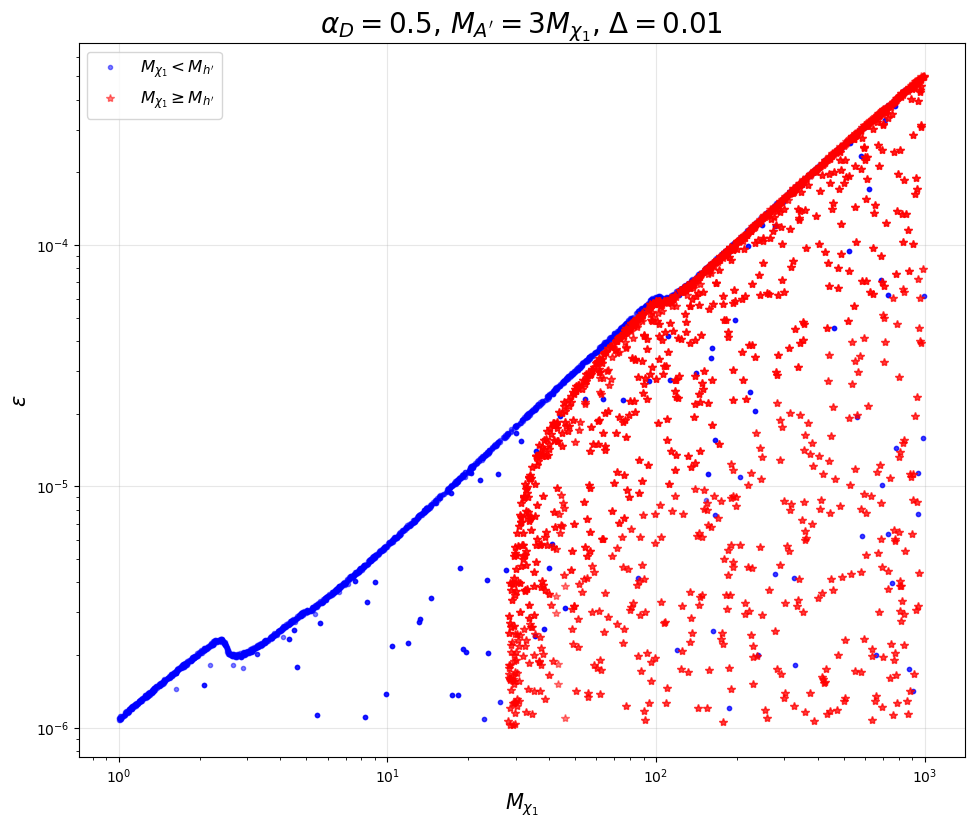

In [111]:



plt.figure(figsize=(10, 8))

# Corregido: parámetros separados por comas
plt.plot(df_agrupado_filtro_Ms2['Mx1'], df_agrupado_filtro_Ms2['epsilon'], '.', color='blue', alpha=0.5,
        label = r'$M_{\chi_{1}}<M_{h^\prime}$')
plt.plot(df_agrupado_filtro_Mx1['Mx1'], df_agrupado_filtro_Mx1['epsilon'], '*', color='red', alpha=0.5,
        label = r'$M_{\chi_{1}} \geq M_{h^\prime}$')


plt.xlabel(r'$M_{\chi_{1}}$', fontsize=15)
plt.ylabel(r'$\epsilon$', fontsize=15)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.xscale('log')
plt.yscale('log')
plt.title(r'$\alpha_{D} = 0.5\text{, } M_{A^{\prime}} = 3 M_{\chi_{1}}\text{, } \Delta = 0.01$',size=20)
plt.savefig('filtro_Delta0p01_alpha0p5.jpg',dpi=300)
plt.show()

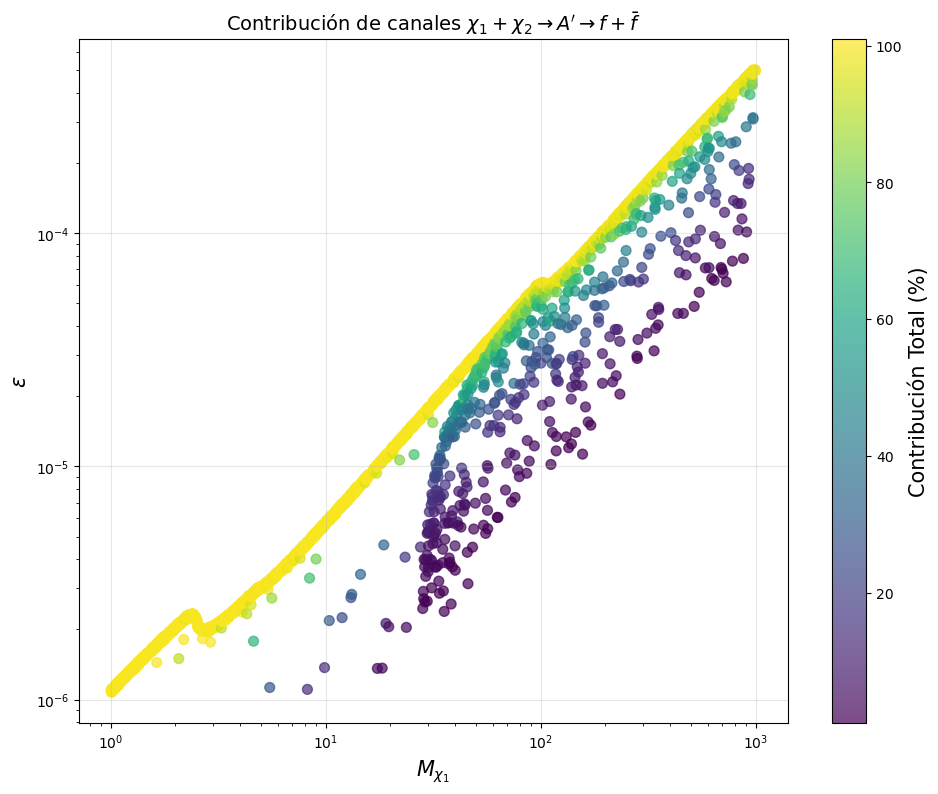

In [36]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(df_chi1_chi2['Mx1'], 
                     df_chi1_chi2['epsilon'], 
                     c=df_chi1_chi2['contribucion_total'], 
                     cmap='viridis', 
                     s=50, 
                     alpha=0.7)

# Añadir barra de color
cbar = plt.colorbar(scatter)
cbar.set_label('Contribución Total (%)', fontsize=15)

# Etiquetas y título
plt.xlabel(r'$M_{\chi_{1}}$', fontsize=15)
plt.ylabel(r'$\epsilon$', fontsize=15)
plt.title(r'Contribución de canales $\chi_{1} + \chi_{2} \rightarrow A^\prime \rightarrow f + \bar{f}$', fontsize=14)

# Mejorar el estilo
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.xscale('log')
plt.yscale('log')
plt.show()

<Figure size 1000x800 with 0 Axes>

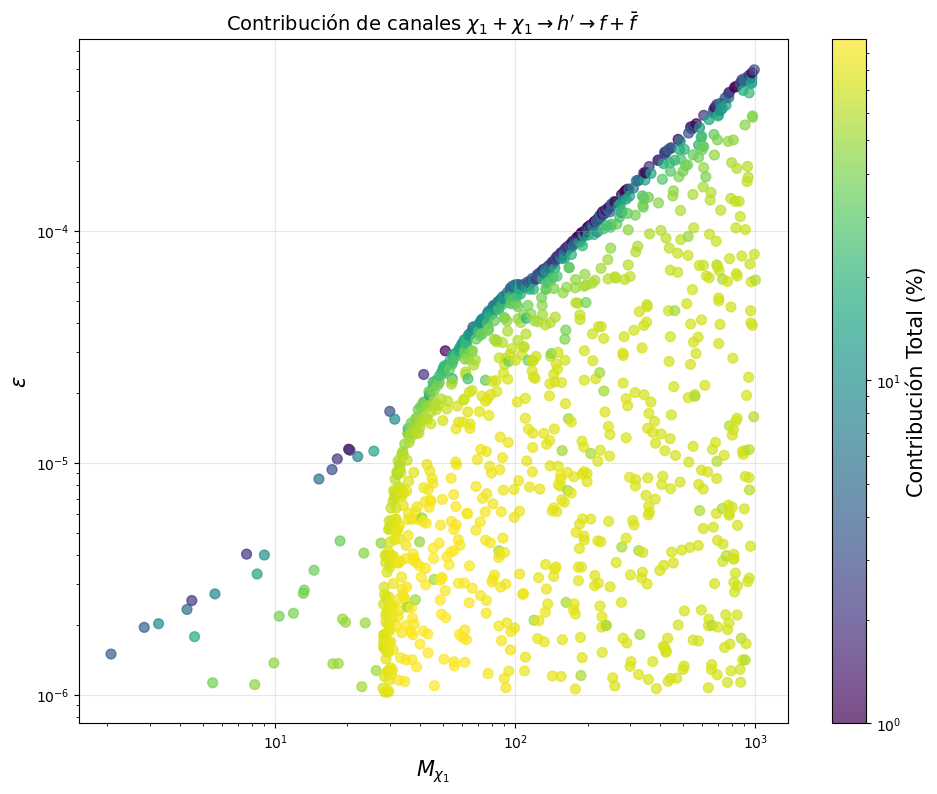

In [39]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(df_sin_phi_phi['Mx1'], 
                     df_sin_phi_phi['epsilon'], 
                     c=df_sin_phi_phi['contribucion_total'], 
                     cmap='viridis', 
                     s=50, 
                     alpha=0.7,
                     norm=colors.LogNorm())

# Añadir barra de color
cbar = plt.colorbar(scatter)
cbar.set_label('Contribución Total (%)', fontsize=15)

# Etiquetas y título
plt.xlabel(r'$M_{\chi_{1}}$', fontsize=15)
plt.ylabel(r'$\epsilon$', fontsize=15)
plt.title(r'Contribución de canales $\chi_{1} + \chi_{1} \rightarrow h^\prime \rightarrow f + \bar{f}$', fontsize=14)

# Mejorar el estilo
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.xscale('log')
plt.yscale('log')
plt.show()

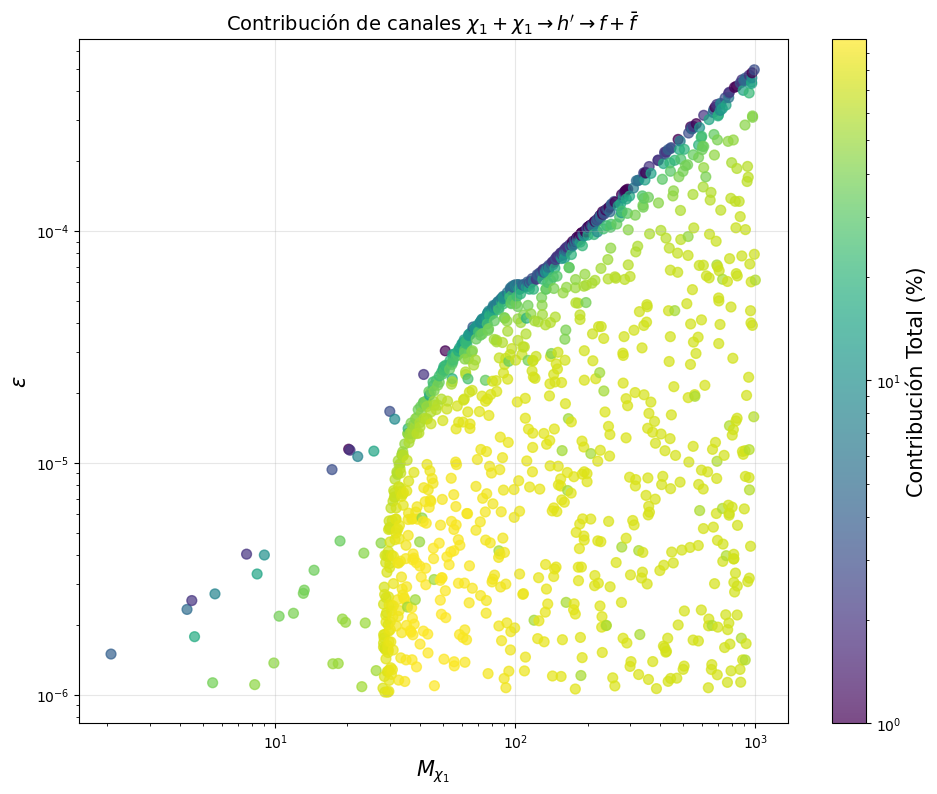

In [49]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(df_con_phi_phi['Mx1'], 
                     df_con_phi_phi['epsilon'], 
                     c=df_con_phi_phi['contribucion_total'], 
                     cmap='viridis', 
                     s=50, 
                     alpha=0.7,
                     norm=colors.LogNorm())

# Añadir barra de color
cbar = plt.colorbar(scatter)
cbar.set_label('Contribución Total (%)', fontsize=15)

# Etiquetas y título
plt.xlabel(r'$M_{\chi_{1}}$', fontsize=15)
plt.ylabel(r'$\epsilon$', fontsize=15)
plt.title(r'Contribución de canales $\chi_{1} + \chi_{1} \rightarrow h^\prime \rightarrow f + \bar{f}$', fontsize=14)

# Mejorar el estilo
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.xscale('log')
plt.yscale('log')
plt.show()

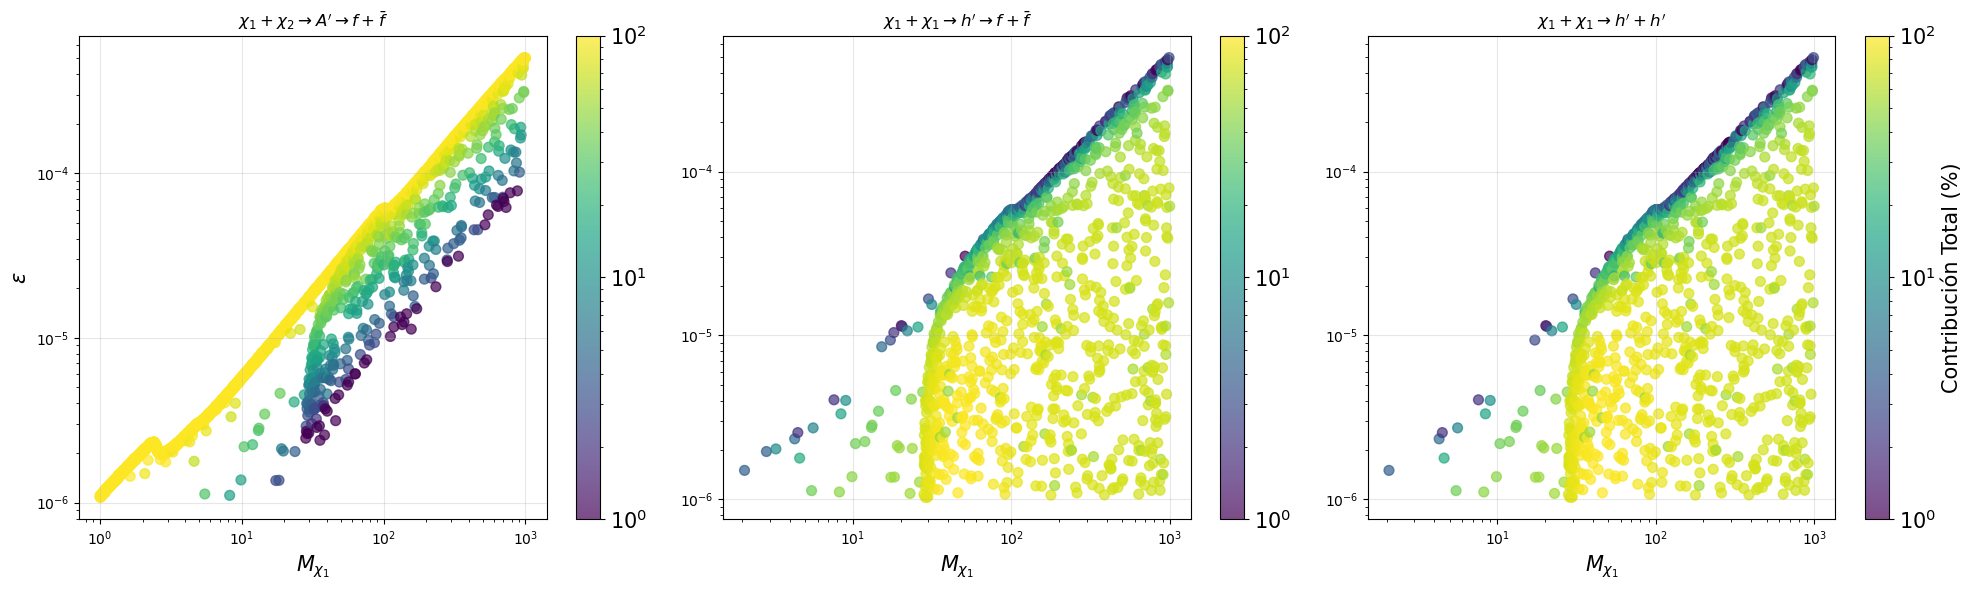

In [112]:
# Configurar límites logarítmicos para la escala de colores
vmin_log = 1  # Mínimo para escala log (no puede ser 0)
vmax_log = 100   # Máximo

# Crear figura con 3 subplots horizontales
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# Primer gráfico: chi1_chi2
scatter1 = ax1.scatter(df_chi1_chi2['Mx1'], 
                      df_chi1_chi2['epsilon'], 
                      c=df_chi1_chi2['contribucion_total'], 
                      cmap='viridis', 
                      s=50, 
                      alpha=0.7,
                      norm=colors.LogNorm(vmin=vmin_log, vmax=vmax_log))

ax1.set_xlabel(r'$M_{\chi_{1}}$', fontsize=15)
ax1.set_ylabel(r'$\epsilon$', fontsize=15)
ax1.set_title(r'$\chi_{1} + \chi_{2} \rightarrow A^\prime \rightarrow f + \bar{f}$', fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.set_xscale('log')
ax1.set_yscale('log')
cbar1 = plt.colorbar(scatter1, ax=ax1)
cbar1.ax.tick_params(labelsize=15)  # Ticks más grandes

# Segundo gráfico: sin phi phi
scatter2 = ax2.scatter(df_sin_phi_phi['Mx1'], 
                      df_sin_phi_phi['epsilon'], 
                      c=df_sin_phi_phi['contribucion_total'], 
                      cmap='viridis', 
                      s=50, 
                      alpha=0.7,
                      norm=colors.LogNorm(vmin=vmin_log, vmax=vmax_log))

ax2.set_xlabel(r'$M_{\chi_{1}}$', fontsize=15)
ax2.set_title(r'$\chi_{1} + \chi_{1} \rightarrow h^\prime \rightarrow f + \bar{f}$', fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.set_xscale('log')
ax2.set_yscale('log')
cbar2 = plt.colorbar(scatter2, ax=ax2)
cbar2.ax.tick_params(labelsize=15)   

# Tercer gráfico: con phi phi
scatter3 = ax3.scatter(df_con_phi_phi['Mx1'], 
                      df_con_phi_phi['epsilon'], 
                      c=df_con_phi_phi['contribucion_total'], 
                      cmap='viridis', 
                      s=50, 
                      alpha=0.7,
                      norm=colors.LogNorm(vmin=vmin_log, vmax=vmax_log))

ax3.set_xlabel(r'$M_{\chi_{1}}$', fontsize=15)
ax3.set_title(r'$\chi_{1} + \chi_{1} \rightarrow  h^\prime + h^\prime $', fontsize=12)
ax3.grid(True, alpha=0.3)
ax3.set_xscale('log')
ax3.set_yscale('log')
cbar3 = plt.colorbar(scatter3, ax=ax3)
cbar3.set_label('Contribución Total (%)', fontsize=15)
cbar3.ax.tick_params(labelsize=15)  # Ticks más grandes

# Ajustar layout
plt.tight_layout()
plt.savefig('Canales_de_contribucion_Delta0p01_alpha0p5.jpg',dpi=300)
plt.show()

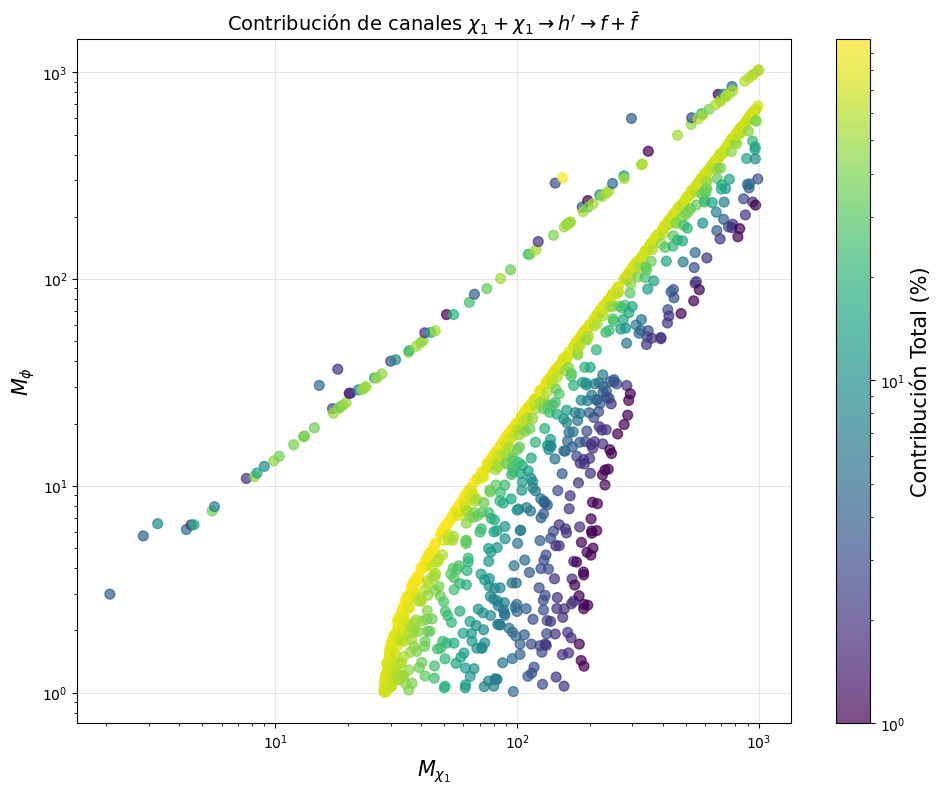

In [41]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(df_sin_phi_phi['Mx1'], 
                     df_sin_phi_phi['Ms2'], 
                     c=df_sin_phi_phi['contribucion_total'], 
                     cmap='viridis', 
                     s=50, 
                     alpha=0.7,
                     norm=colors.LogNorm())

# Añadir barra de color
cbar = plt.colorbar(scatter)
cbar.set_label('Contribución Total (%)', fontsize=15)

# Etiquetas y título
plt.xlabel(r'$M_{\chi_{1}}$', fontsize=15)
plt.ylabel(r'$M_{\phi}$', fontsize=15)
plt.title(r'Contribución de canales $\chi_{1} + \chi_{1} \rightarrow h^\prime \rightarrow f + \bar{f}$', fontsize=14)

# Mejorar el estilo
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.xscale('log')
plt.yscale('log')
plt.show()

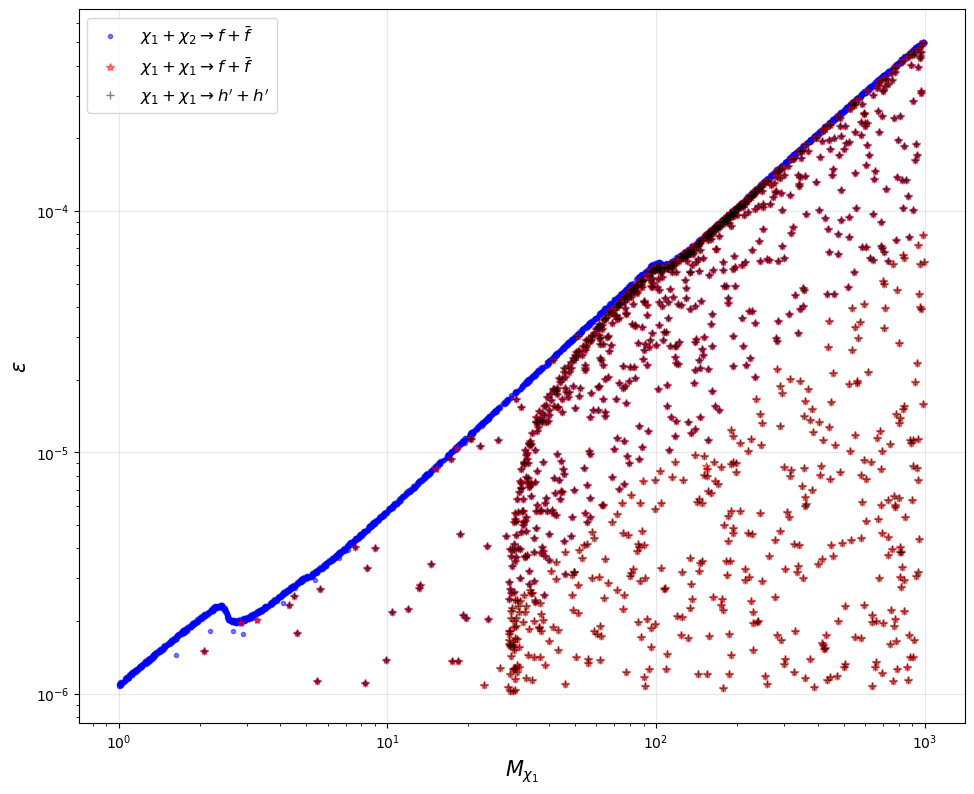

In [76]:
plt.figure(figsize=(10, 8))

# Corregido: parámetros separados por comas
plt.plot(df_chi1_chi2['Mx1'], df_chi1_chi2['epsilon'], '.', color='blue',
         label=r'$\chi_{1} + \chi_{2} \rightarrow f + \bar{f}$', alpha=0.5)

plt.plot(df_sin_phi_phi['Mx1'], df_sin_phi_phi['epsilon'], '*', color='red', 
         label=r'$\chi_{1} + \chi_{1} \rightarrow f + \bar{f}$', alpha=0.5)

plt.plot(df_con_phi_phi['Mx1'], df_con_phi_phi['epsilon'], '+', color='black',
         label=r'$\chi_{1} + \chi_{1} \rightarrow h^\prime + h^\prime$', alpha=0.5)

plt.xlabel(r'$M_{\chi_{1}}$', fontsize=15)
plt.ylabel(r'$\epsilon$', fontsize=15)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.xscale('log')
plt.yscale('log')
plt.show()

In [ ]:
df_con_phi_phi